In [39]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [40]:
plt.rcParams['font.family'] = 'sans-serif'

# Helper functions

In [41]:
def plotA(
    df, plot_key, plot_epoch,
    fnames=None, figname=None,
    smooth_line=True, smooth_n=5, smooth_plot=True, colors=None):
    
    fig, ax = plt.subplots()
    zs = np.sort(np.unique(df['z']))
    epochs = np.sort(np.unique(df['epochs']))
    if fnames is None:
        fnames = np.unique(df['fname'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            means = []
            sems = []
            df_subset = df[(df['fname']==fname) & (df['z']==z)]
            for epoch in epochs:
                vals = df_subset[df_subset['epochs']==epoch]
                vals = vals[plot_key]
                means.append(np.mean(vals))
                sems.append(sem(vals))
            means = np.array(means)
            sems = np.array(sems)
            mean_lowerbound = means - sems
            mean_upperbound = means + sems
            if smooth_line:
                means = smooth(epochs, means, smooth_n)
                mean_lowerbound = smooth(epochs, mean_lowerbound)
                mean_upperbound = smooth(epochs, mean_upperbound)
            line.append(means[plot_epoch])
            shading_lower.append(mean_lowerbound[plot_epoch])
            shading_upper.append(mean_upperbound[plot_epoch])
        if smooth_plot:
            _line = smooth(zs, line, 2)
            _shading_lower = smooth(zs, shading_lower, 2)
            _shading_upper = smooth(zs, shading_upper, 2)
            _line[0] = line[0]; _line[-1] = line[-1]
            _shading_lower[0] = shading_lower[0]
            _shading_lower[-1] = shading_lower[-1]
            _shading_upper[0] = shading_upper[0]
            _shading_upper[-1] = shading_upper[-1]
            line = _line; shading_lower = _shading_lower;
            shading_uppper = _shading_upper
        x_axis = zs/26
        if colors is not None:
            color = colors[fname_idx]
        ax.plot(x_axis, line, label=fname, color=color)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.4,color=color)
    plt.ylabel('Avg Episode Score')
    plt.xlabel('Decoder Size (multiple)')
    plt.xticks([0.75, 1, 1.25], ['$0.75$x', '$1$x', '$1.25$x'])
    plt.legend(title='Auxiliary Task', title_fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [42]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

'mf' is actually 'sr_15_0.93'
'mbentro' is actually 'mb'
'sr_15_0.93' is actually 'entro'

# Transfer Results

In [43]:
zs = np.arange(10, 26) #[16, 18, 20, 22, 24, 26, 28, 30, 32, 34] #np.arange(14, 32)

In [44]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [45]:
transfer_data = {
    'performance': [], 'dims': [], 'epochs': [],
    'fname': [], 'z': [], 'steps': []
    }
for z in zs:
#     if z == 26:
#         transfer_dir = f'transfer_sr_dm_dim{z}'
#     else:
    transfer_dir = f'bottleneck_dm_dim{z}'
    transfer_dir = f'{engram_dir}pickles/{transfer_dir}/'
    if not os.path.exists(transfer_dir):
        continue
    for pickle_file in os.listdir(transfer_dir):
        pickle_file = f'{transfer_dir}{pickle_file}'
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_scores = results['valid_scores']
        valid_steps = results['valid_steps']
        dimensionality_tracking = results['dimensionality_tracking']
        fnames = results['fname']
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        multiple = int(n_fname/n_scores)
        for idx in range(n_scores):
            perf = valid_scores[idx]
            steps = valid_steps[idx]
            dim = dimensionality_tracking[idx]
            fname = fnames[idx*multiple]
            if fname.endswith('mb_only'):
                fname = 'MB only'
            elif 'mb' in fname:
                fname = 'MB + Entropy'
            elif 'mf' in fname:
                fname = 'None'
            elif 'entro' in fname:
                fname = 'Entropy'
            elif 'clean' in fname:
                fname = 'Random'
            elif '_sr_' in fname and '.9' in fname:
                fname = 'SR'
            elif '_sr_' in fname:
                fname = f'SR $\gamma={fname[-3:]}$'
            for epoch in range(len(perf)):
                transfer_data['performance'].append(perf[epoch])
                transfer_data['steps'].append(steps[epoch])
                transfer_data['dims'].append(dim)
                transfer_data['epochs'].append(epoch)
                transfer_data['fname'].append(fname)
                transfer_data['z'].append(z)
transfer_df = pd.DataFrame(transfer_data)

In [46]:
np.unique(transfer_df['fname'])

array([], dtype=float64)

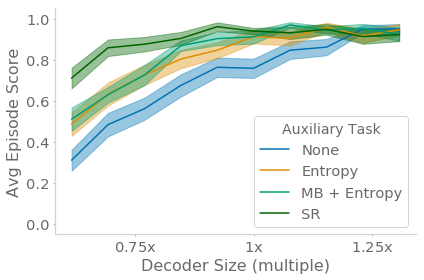

In [15]:
plotA(transfer_df, 'performance', 10, smooth_line=True, smooth_n=3,
      fnames=['None', 'Entropy', 'MB + Entropy', 'SR'],
      smooth_plot=False, figname='decodersize_transfer_early',
      colors=['C0', 'C1', 'C2', 'darkgreen'])

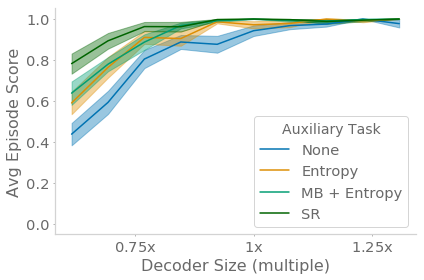

In [16]:
plotA(transfer_df, 'performance', 35, smooth_line=True, smooth_n=3,
      fnames=['None', 'Entropy', 'MB + Entropy', 'SR'], smooth_plot=False,
      figname='decodersize_transfer_late',
      colors=['C0', 'C1', 'C2', 'darkgreen'])

# Task A Results

In [19]:
taskA_data = {
    'performance': [], 'dims': [], 'epochs': [],
    'fname': [], 'z': [], 'steps': []
    }
for z in zs:
    if z == 26:
        taskA_dir = f'sr_dm_dim{z}'
    else:
        taskA_dir = f'srSize_dm_dim{z}'
    taskA_dir = f'{engram_dir}pickles/{taskA_dir}/'
    if not os.path.exists(taskA_dir):
        continue
    for pickle_file in os.listdir(taskA_dir):
        pickle_file = f'{taskA_dir}{pickle_file}'
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_scores = results['valid_scores']
        valid_steps = results['valid_steps']
        dimensionality_tracking = results['dimensionality_tracking']
        fnames = results['fname']
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        multiple = int(n_fname/n_scores)
        for idx in range(n_scores):
            perf = valid_scores[idx]
            steps = valid_steps[idx]
            dim = dimensionality_tracking[idx]
            fname = fnames[idx*multiple]
            if fname.endswith('mb_only'):
                fname = 'MB only'
            elif 'mb' in fname:
                fname = 'MB + Entropy'
            elif 'mf' in fname:
                fname = 'None'
            elif 'entro' in fname:
                fname = 'Entropy'
            elif 'clean' in fname:
                fname = 'Random'
            elif '_sr_' in fname and '.9' in fname:
                fname = f'SR'
            elif '_sr_' in fname:
                fname = f'SR $\gamma={fname[-3:]}$'
            for epoch in range(len(perf)):
                taskA_data['performance'].append(perf[epoch-1])
                taskA_data['steps'].append(steps[epoch-1])
                taskA_data['dims'].append(dim)
                taskA_data['epochs'].append(epoch)
                taskA_data['fname'].append(fname)
                taskA_data['z'].append(z)
taskA_df = pd.DataFrame(taskA_data)

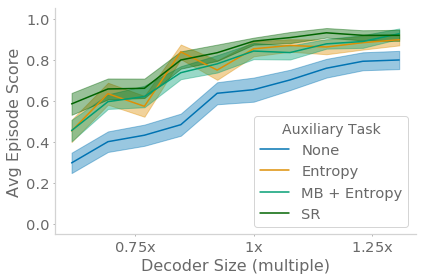

In [20]:
plotA(taskA_df, 'performance', 10, smooth_line=True, smooth_n=3,
      fnames=['None', 'Entropy', 'MB + Entropy', 'SR'],
      smooth_plot=False, figname='decodersize_foraging_early',
     colors=['C0', 'C1', 'C2', 'darkgreen'])

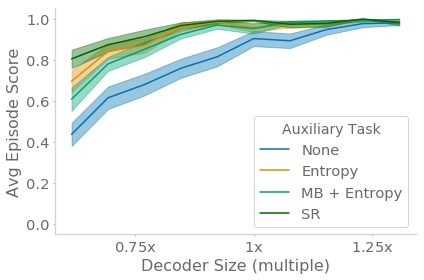

In [21]:
plotA(taskA_df, 'performance', 35, smooth_line=True, smooth_n=3,
      fnames=['None', 'Entropy', 'MB + Entropy', 'SR'], smooth_plot=False,
      figname='decodersize_foraging_late',
     colors=['C0', 'C1', 'C2', 'darkgreen'])

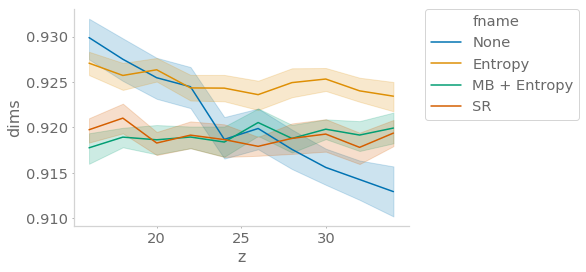

In [38]:
plot_df = taskA_df[taskA_df['epochs']==35]
sns.lineplot(y='dims', x='z', hue='fname',
    data=plot_df,
    hue_order=['None', 'Entropy', 'MB + Entropy', 'SR'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)